# 1. Data

In [1]:
# loading necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('thl_recoded.csv')
data.head()

,kannabis,k9,k12,alcohol_use,k21a,k21b,risk_of_use,risk_of_try,cannabis_access,other_access,...,k70b_3.0,k70b_4.0,k70c_2.0,k70c_3.0,k70c_4.0,k70d_2.0,k70d_3.0,k70d_4.0,k70e_3.0,k70e_4.0
0,0.0,4.0,4.0,7.0,2.0,1.0,20.0,13.0,2.0,2.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,0.0,3.0,3.0,6.0,3.0,3.0,22.0,14.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,0.0,5.0,5.0,7.0,3.0,2.0,21.0,13.0,2.0,3.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,0.0,3.0,5.0,6.0,2.0,1.0,22.0,11.0,3.0,3.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,0.0,3.0,5.0,6.0,2.0,3.0,21.0,12.0,1.0,3.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [3]:
 # Kannabis use
data['kannabis'].value_counts(normalize= True)

0.0    0.934577
1.0    0.065423
Name: kannabis, dtype: float64

## 1.1. Combination of Over- and Under-sampling/ Hybrid Methods

In the previous stage, we learned that the best sampling strategy for this data set is hybrit method. For that reason, we will continue with this method for the rest of the re-sampling processes.  

In [4]:
# resample by adding samples to minority class using SMOTE
from collections import Counter
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

from sklearn.model_selection import train_test_split
X, y = data.iloc[:, 1:].values, data.iloc[:, 0].values

resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
X_oversamp, Y_over_samp = resample.fit_resample(X, y)



#split data train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_oversamp,
                                                    Y_over_samp,
                                                    test_size=0.3,
                                                    random_state = 10)



print(f"Class counts after resampling {Counter( Y_over_samp)}")

Class counts after resampling Counter({0.0: 3257, 1.0: 3257})


# 2. Selecting best classifier with RFEVC
This is a fast method to check which classifier works better. RFECV determines number of features automatically, so in this stage, we are not interested in how many features are in the model, instead, which model produce higer accuracy rate. Since it is an unbalanced data, I will use f1 score for model performance. 

Xboost changed its algorithms, I do not have time to fix it here, so I just muted it. 

In [5]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.pipeline import Pipeline


# create pipeline of differennt base algorithms to be used in RFECV 
# (no. of features will be auto-selected based on cv in RFECV)
models = {}
# logistic regression
rfecv = RFECV(estimator = LogisticRegression(solver='lbfgs', max_iter=1000), cv = 2, scoring = 'f1_macro')
model = DecisionTreeClassifier()
models['LR'] = Pipeline(steps = [('features', rfecv), ('model', model)])
# decision tree
rfecv = RFECV(estimator = DecisionTreeClassifier(), cv = 5, scoring = 'f1_macro')
model = DecisionTreeClassifier()
models['DT'] = Pipeline(steps = [('features', rfecv), ('model', model)])
# random forest
rfecv = RFECV(estimator = RandomForestClassifier(), cv = 5, scoring = 'f1_macro')
model = DecisionTreeClassifier()
models['RF'] = Pipeline(steps = [('features', rfecv), ('model', model)])

# XGBoost Classifier
#rfecv = RFECV(estimator=XGBClassifier(), cv = 2, scoring = 'accuracy')
#model = DecisionTreeClassifier()
#models['XGB'] = Pipeline(steps = [('features', rfecv), ('model', model)])


# Gradient Boosting Classifier
rfecv = RFECV(estimator=GradientBoostingClassifier(), cv = 5, scoring = 'f1_macro')
model = DecisionTreeClassifier()
models['GBC'] = Pipeline(steps = [('features', rfecv), ('model', model)])

# Perceptron
rfecv = RFECV(estimator=Perceptron(), cv = 5, scoring = 'f1_macro')
model = DecisionTreeClassifier()
models['PER'] = Pipeline(steps = [('features', rfecv), ('model', model)])


# SCV - default rbf
rfecv = RFECV(estimator= SVC(kernel='linear'), cv = 5, scoring = 'f1_macro')
model = DecisionTreeClassifier()
models['SVC'] = Pipeline(steps = [('features', rfecv), ('model', model)])


# evaluate all the models
results = []
names = []
for name, model in models.items():
    cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5, random_state = 1)
    scores = cross_val_score(model, X, y, scoring = 'accuracy', cv = cv, n_jobs = -1)
    results.append(scores)
    names.append(name)
    print('>%s: %.3f' % (name, np.mean(scores)))

>LR: 0.940
>DT: 0.936
>RF: 0.937
>GBC: 0.936
>PER: 0.934
>SVC: 0.938


**Summary:** Results show that LR and SVC models have a higher f1 score on feature elimination. However, we do not know yet how many features the models used to produce these resutls. 

## 2.1. RFE Classifier with a given number of features

In this stage, we can give a predetermined feature size and look for model performances. Put differently, let's say if we want to use less than 20 features, which model have higher f1 scores. 

In [6]:

# explore the algorithm wrapped by RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

In [7]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # lr
    rfe = RFE(estimator=LogisticRegression(solver='lbfgs', max_iter=1000), n_features_to_select=20)
    model = DecisionTreeClassifier()
    models['lr'] = Pipeline(steps=[('s',rfe),('m',model)])
    # perceptron
    rfe = RFE(estimator=Perceptron(), n_features_to_select=20)
    model = DecisionTreeClassifier()
    models['per'] = Pipeline(steps=[('s',rfe),('m',model)])
    # cart
    rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=20)
    model = DecisionTreeClassifier()
    models['cart'] = Pipeline(steps=[('s',rfe),('m',model)])
    # rf
    rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=20)
    model = DecisionTreeClassifier()
    models['rf'] = Pipeline(steps=[('s',rfe),('m',model)])
    # gbm
    rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=20)
    model = DecisionTreeClassifier()
    models['gbm'] = Pipeline(steps=[('s',rfe),('m',model)])
    # SCV - default rbf
    rfe = RFE(estimator= SVC(kernel='linear'), n_features_to_select=20)
    model = DecisionTreeClassifier()
    models['SVC'] = Pipeline(steps = [('s',rfe),('m',model)])

    
    

    return models

In [8]:
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
    scores = cross_val_score(model, X, y, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores

In [9]:
# get the models to evaluate
models = get_models()

>lr 0.746 (0.030)
>per 0.742 (0.032)
>cart 0.740 (0.030)
>rf 0.744 (0.032)
>gbm 0.743 (0.032)
>SVC 0.755 (0.030)


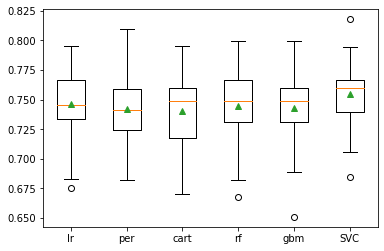

In [10]:
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

**Summary:** The resutls show that SCV performs well with 20 features but there are some outliers in the grapgh. The RF and GBM seems more promissing for the next stage.

# 3. Select the minumum features

In this stage, we will look at more closely to the models, their performance and features they give importance. Here, we basically determine a model that works well for our expectations. 


In [11]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
import numpy as np


In [12]:
def feature_selection(X, y, model, estimator, n_split, n_repeat ):
    from sklearn.feature_selection import RFECV
    
    model_estimator = estimator
    
    X_train = X
    y_train = y
    
    #  RFECV model 
    rfecv = RFECV(estimator= model_estimator)
    model = model
    
    pipeline = Pipeline([('Feature Selection', rfecv), ('Model', model)])
    cv = RepeatedStratifiedKFold(n_splits=n_split, n_repeats=n_repeat, random_state=92116)
    n_scores = cross_val_score(pipeline, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    np.mean(n_scores)
    

    # model fit 
    pipeline.fit(X_train, y_train)
    print('Optimal number of features : %d' % rfecv.n_features_)


    # Confusion matrix 
    y_pred = pipeline.predict(X_test)
    from sklearn import metrics
    from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import accuracy_score

    print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
    print('Precision:', np.round(metrics.precision_score(y_test, y_pred,average='weighted'),4))
    print('Recall:', np.round(metrics.recall_score(y_test, y_pred,
                                               average='weighted'),4))
    print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred,
                                               average='weighted'),4))
    print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
    print('Matthews Corrcoef:', np.round(metrics.matthews_corrcoef(y_test, y_pred),4)) 

    from sklearn.metrics import roc_auc_score
    print("roc_auc_score:", roc_auc_score(y_test, y_pred, average=None))

    print('\t\tClassification Report:\n', metrics.classification_report(y_pred,y_test))


    from sklearn.metrics import confusion_matrix
    print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred))


    #Plot Confusion Matrix
    from sklearn.metrics import confusion_matrix
    from io import BytesIO #neded for plot
    import seaborn as sns; sns.set()
    import matplotlib.pyplot as plt

    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)


    plt.xlabel('true label')
    plt.ylabel('predicted label');
    
    
    # Feature plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,6))
    plt.xlabel('Number of features selected')
    plt.ylabel('Cross validation score (nb of correct classifications)')
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
    # List of features
    rfecv.support_rfecv_df = pd.DataFrame(rfecv.ranking_,index=data.columns[1:],columns=['Rank']).sort_values(by='Rank',ascending=True)

    dt_columns = rfecv.support_rfecv_df [rfecv.support_rfecv_df ['Rank']==1].reset_index()
    dt_columns = list(np.array(dt_columns['index']))
    

    

    return rfecv.support_rfecv_df
    
    
    


#  3.1. RFE GradientBoostingClassifier - Automatic Feature Selection

Optimal number of features : 31
Accuracy: 0.978
Precision: 0.978
Recall: 0.978
F1 Score: 0.978
Cohen Kappa Score: 0.956
Matthews Corrcoef: 0.956
roc_auc_score: 0.9780010465724751
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       972
         1.0       0.98      0.98      0.98       983

    accuracy                           0.98      1955
   macro avg       0.98      0.98      0.98      1955
weighted avg       0.98      0.98      0.98      1955

Confusion Matrix:
 [[952  23]
 [ 20 960]]


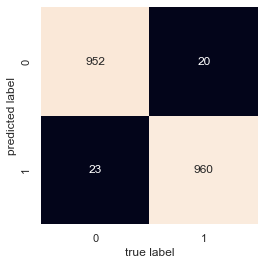

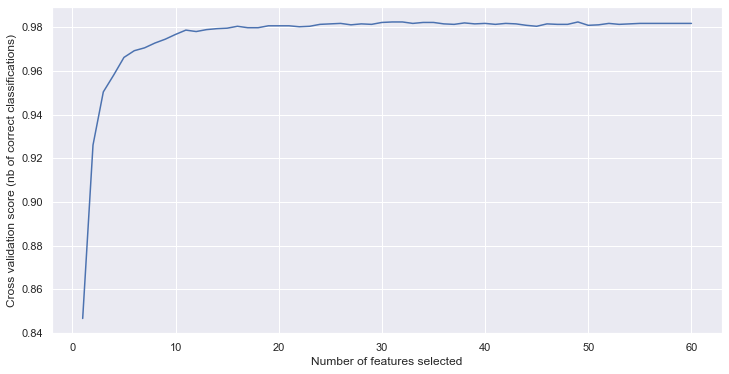

,Rank
k9,1
"age_bins_(24, 34]",1
employment_1,1
violence_treat_1,1
drug_offer_1,1
drug_user_friend_1,1
k23g_2.0,1
k3_3.0,1
k4_2.0,1
k23d_2.0,1


In [13]:
from sklearn.ensemble import GradientBoostingClassifier
estimator = GradientBoostingClassifier()
model = GradientBoostingClassifier()
# crosvalidation 
n_split = 5
n_repeat = 5


feature_selection(X_train, y_train, model, estimator,  n_split, n_repeat)

# RFE Randon Forest -  Automatic Feature Selection

Optimal number of features : 24
Accuracy: 0.9775
Precision: 0.9775
Recall: 0.9775
F1 Score: 0.9775
Cohen Kappa Score: 0.955
Matthews Corrcoef: 0.955
roc_auc_score: 0.9774960753532183
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       977
         1.0       0.98      0.98      0.98       978

    accuracy                           0.98      1955
   macro avg       0.98      0.98      0.98      1955
weighted avg       0.98      0.98      0.98      1955

Confusion Matrix:
 [[954  21]
 [ 23 957]]


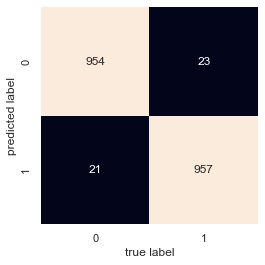

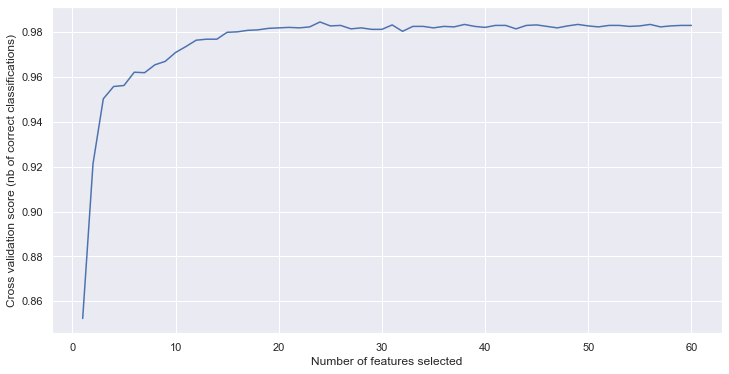

,Rank
k9,1
k70d_4.0,1
k70c_4.0,1
k70b_4.0,1
k70b_3.0,1
k4_3.0,1
k70e_3.0,1
violence_treat_1,1
drug_offer_1,1
drug_user_friend_1,1


In [14]:
from sklearn.ensemble import RandomForestClassifier

estimator= RandomForestClassifier()
model = RandomForestClassifier(n_estimators=100, random_state=92116)

# crosvalidation 
n_split = 5
n_repeat = 5


feature_selection(X_train, y_train,  model, estimator, n_split, n_repeat)

# 3.2. RFECV Decision Tree  - Automatic Feature Selection

Optimal number of features : 23
Accuracy: 0.9616
Precision: 0.9617
Recall: 0.9616
F1 Score: 0.9616
Cohen Kappa Score: 0.9233
Matthews Corrcoef: 0.9233
roc_auc_score: 0.9616221873364731
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.97      0.96       964
         1.0       0.97      0.96      0.96       991

    accuracy                           0.96      1955
   macro avg       0.96      0.96      0.96      1955
weighted avg       0.96      0.96      0.96      1955

Confusion Matrix:
 [[932  43]
 [ 32 948]]


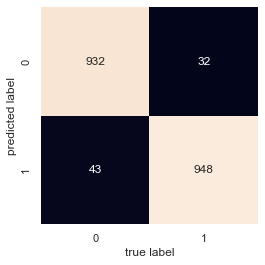

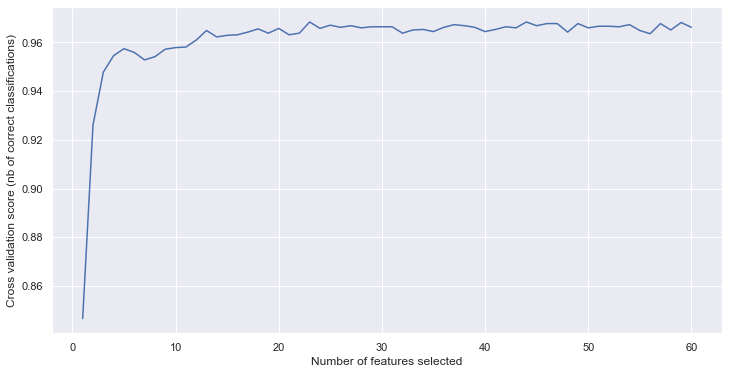

,Rank
k23d_2.0,1
k70b_3.0,1
violence_treat_1,1
k4_4.0,1
employment_1,1
k70b_4.0,1
k70e_3.0,1
non_medicide_1,1
k70c_3.0,1
k70c_4.0,1


In [16]:
from sklearn.tree import DecisionTreeClassifier

estimator= DecisionTreeClassifier()
model = DecisionTreeClassifier()

# crosvalidation 
n_split = 5
n_repeat = 5


feature_selection(X_train, y_train,  model, estimator, n_split, n_repeat)






# 3.3. RFECV LR - Automatic Feature Selection

Optimal number of features : 54
Accuracy: 0.9412
Precision: 0.9421
Recall: 0.9412
F1 Score: 0.9411
Cohen Kappa Score: 0.8823
Matthews Corrcoef: 0.8833
roc_auc_score: 0.9411172161172161
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.96      0.94       930
         1.0       0.96      0.92      0.94      1025

    accuracy                           0.94      1955
   macro avg       0.94      0.94      0.94      1955
weighted avg       0.94      0.94      0.94      1955

Confusion Matrix:
 [[895  80]
 [ 35 945]]


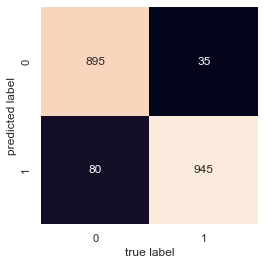

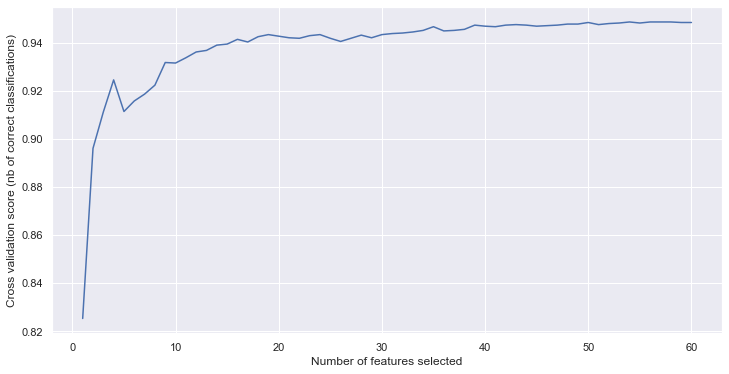

,Rank
k9,1
"age_bins_(44, 54]",1
"age_bins_(54, 70]",1
k3_2.0,1
k3_3.0,1
k3_5.0,1
k3_6.0,1
k4_2.0,1
k4_3.0,1
k4_5.0,1


In [17]:
from sklearn.linear_model import LogisticRegression

estimator= LogisticRegression(solver='lbfgs', max_iter=1000)
model = LogisticRegression(solver='lbfgs', max_iter=1000)

# crosvalidation 
n_split = 5
n_repeat = 5


feature_selection(X_train, y_train,  model, estimator, n_split, n_repeat)

# 4. SHARP RFECV 

ShapRFECV, a new method for feature selection in decision-tree-based models that is particularly well-suited to binary classification problems.

In a nutshell, SHAP computes Shapley values, which represent the contribution of a given feature towards the prediction of the model for a given sample. The further the value is from 0 for a given prediction, the stronger the influence of that feature is, while the sign of the value represents the class towards which the prediction is pushed by that feature.

I also tested Sharp RFECF here and if you want to learn more about, please [check this post.](https://medium.com/ing-blog/open-sourcing-shaprfecv-improved-feature-selection-powered-by-shap-994fe7861560) 

In [18]:
from probatus.feature_elimination import ShapRFECV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=5, class_weight='balanced')

param_grid = {
    'n_estimators': [5, 10, 15, 20],
    'min_samples_leaf': [3, 5, 7, 10],
}
search = RandomizedSearchCV(clf, param_grid)



shap_elimination = ShapRFECV(search, step=0.2, cv=5, scoring='roc_auc', n_jobs=3)
report = shap_elimination.fit_compute(X, y)


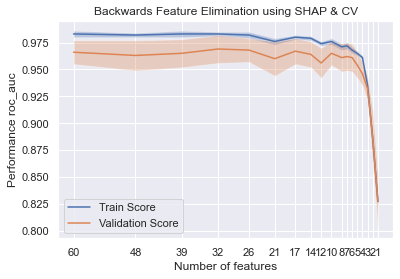

In [22]:


# Make plots
performance_plot = shap_elimination.plot()

# Get final feature set
final_features_set = shap_elimination.get_reduced_features_set(num_features=5)

In [23]:
#First 5 rows of first 5 columns
report[['num_features', 'features_set', 'val_metric_mean']]

,num_features,features_set,val_metric_mean
1,60,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.966
2,48,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.963
3,39,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.965
4,32,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14,...",0.969
5,26,"[0, 1, 2, 3, 5, 6, 7, 8, 10, 12, 14, 15, 16, 1...",0.968
6,21,"[0, 1, 2, 3, 5, 6, 7, 8, 10, 14, 15, 16, 17, 2...",0.960
7,17,"[0, 1, 2, 3, 5, 6, 7, 8, 15, 17, 20, 24, 25, 3...",0.967
8,14,"[0, 1, 2, 3, 5, 6, 7, 17, 20, 24, 25, 50, 51, 59]",0.964
9,12,"[0, 1, 3, 5, 6, 7, 17, 50, 51, 20, 24, 25]",0.956
10,10,"[0, 1, 6, 7, 17, 50, 51, 20, 24, 25]",0.965


In [24]:
shap_elimination.get_reduced_features_set(num_features=10)


[0, 1, 6, 7, 17, 50, 51, 20, 24, 25]

You can also provide a list of features that should not be eliminated. Say based on your prior knowledge you know that the features f10,f19,f15 are important and should not be eliminated. This can be done by providing a list of columns to columns_to_keep parameter in the fit() function.

[More info](https://colab.research.google.com/github/ing-bank/probatus/blob/master/docs/tutorials/nb_shap_feature_elimination.ipynb#scrollTo=IODaPwATqyFo)

In [27]:
#shap_elimination = ShapRFECV(clf=search, step=0.2, cv=10, scoring='roc_auc', n_jobs=3  ,min_features_to_select=4)
#report = shap_elimination.fit_compute(X, y, columns_to_keep=['k9','age_bins_(44, 54]','k23d_2.0'])
#performance_plot = shap_elimination.plot()

## 4.1 EarlyStoppingShapRFECV


[Early stopping](https://en.wikipedia.org/wiki/Early_stopping) is a type of regularization, common in [gradient boosted trees](https://en.wikipedia.org/wiki/Gradient_boosting#Gradient_tree_boosting). Supported packages are: [LightGBM](https://lightgbm.readthedocs.io/en/latest/index.html), [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html) and [CatBoost](https://catboost.ai/en/docs/). It consists of measuring how well the model performs after each base learner is added to the ensemble tree, using a relevant scoring metric. If this metric does not improve after a certain number of training steps, the training can be stopped before the maximum number of base learners is reached. 

Early stopping is thus a way of mitigating overfitting in a relatively cheaply, without having to find the ideal regularization hyperparameters. It is particularly useful for handling large datasets, since it reduces the number of training steps which can decrease the modelling time.

`EarlyStoppingShapRFECV` is a child of `ShapRFECV` with limited support for early stopping and the example below shows how to use it with LightGBM.

This model do not work for our data set but you may want to test on your own data. 

In [29]:
import lightgbm
from probatus.feature_elimination import EarlyStoppingShapRFECV

clf = lightgbm.LGBMClassifier(n_estimators=100, max_depth=3)

# Run feature elimination
shap_elimination = EarlyStoppingShapRFECV(
    clf=search, step=0.2, cv=10, scoring='roc_auc', eval_metric='auc', early_stopping_rounds=5, n_jobs=3)
#report = shap_elimination.fit_compute(X, y)


In [ ]:
# Make plots
performance_plot = shap_elimination.plot()

# Get final feature set
final_features_set = shap_elimination.get_reduced_features_set(num_features=9)

As it is hinted in the example above, with large datasets and simple base learners, early stopping can be a much faster alternative to hyperparameter optimization of the ideal number of trees.
Note that although EarlyStoppingShapRFECV supports hyperparameter search models as input, early stopping is used only during the Shapley value estimation step, and not during hyperparameter search. For this reason, if you are not using early stopping, you should use the parent class, ShapRFECV, instead of EarlyStoppingShapRFECV

# 5. Final Process

Our results shows that GBM produces the better results with less features. To analyze it more in details and extract the features, we will conduct RFE analysis. 

In [77]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier

In [85]:
rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=20)
model = GradientBoostingClassifier()
pipeline = Pipeline([('Feature Selection', rfe), ('Model', model)])
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=36851234)
n_scores = cross_val_score(pipeline, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
np.mean(n_scores)


0.9806525567991339

In [86]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('Feature Selection',
                 RFE(estimator=GradientBoostingClassifier(),
                     n_features_to_select=20)),
                ('Model', GradientBoostingClassifier())])

Accuracy: 0.977
Precision: 0.977
Recall: 0.977
F1 Score: 0.977
Cohen Kappa Score: 0.954
Matthews Corrcoef: 0.954
roc_auc_score: 0.976975405546834
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.98      0.98       970
         1.0       0.98      0.97      0.98       985

    accuracy                           0.98      1955
   macro avg       0.98      0.98      0.98      1955
weighted avg       0.98      0.98      0.98      1955

Confusion Matrix:
 [[950  25]
 [ 20 960]]


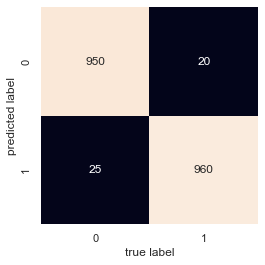

In [87]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred = pipeline.predict(X_test)

print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred,average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test, y_pred,
                                               average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred,
                                               average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('Matthews Corrcoef:', np.round(metrics.matthews_corrcoef(y_test, y_pred),4)) 

from sklearn.metrics import roc_auc_score
print("roc_auc_score:", roc_auc_score(y_test, y_pred, average=None))

print('\t\tClassification Report:\n', metrics.classification_report(y_pred,y_test))


from sklearn.metrics import confusion_matrix
print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred))


#Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
from io import BytesIO #neded for plot
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)


plt.xlabel('true label')
plt.ylabel('predicted label');

plt.savefig("Confusion.jpg")
# Save SVG in a fake file object.
f = BytesIO()
plt.savefig(f, format="svg")

In [88]:
rfe.support_

array([ True,  True,  True,  True, False,  True,  True,  True, False,
        True, False, False,  True, False, False,  True,  True,  True,
       False, False,  True, False, False, False,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True, False, False,
       False, False, False, False,  True, False])

In [89]:
pd.DataFrame(rfe.support_,index=data.columns[1:],columns=['Rank'])

,Rank
k9,True
k12,True
alcohol_use,True
k21a,True
k21b,False
risk_of_use,True
risk_of_try,True
cannabis_access,True
other_access,False
doping_access,True


In [90]:
rf_df = pd.DataFrame(rfe.ranking_,index=data.columns[1:],columns=['Rank']).sort_values(by='Rank',ascending=True)
rf_df

,Rank
k9,1
k70e_3.0,1
violence_treat_1,1
drug_offer_1,1
drug_user_friend_1,1
k4_3.0,1
k23d_2.0,1
k70b_3.0,1
k23a_2.0,1
k6_2.0,1


In [91]:
# list of features for further use

dt_cloumns = rf_df[rf_df['Rank']==1].reset_index()
dt_cloumns= dt_cloumns['index'].to_list()
dt_cloumns

['k9',
 'k70e_3.0',
 'violence_treat_1',
 'drug_offer_1',
 'drug_user_friend_1',
 'k4_3.0',
 'k23d_2.0',
 'k70b_3.0',
 'k23a_2.0',
 'k6_2.0',
 'k70b_4.0',
 'k72',
 'non_medicide_1',
 'risk_of_use',
 'doping_access',
 'cannabis_access',
 'k12',
 'risk_of_try',
 'k21a',
 'alcohol_use']

# 6. Summary 

These 20 features are enough to predict cannabis use with a %98 accuracy rate. In the next stage, we will look a bit more closer to the feature and then build a prediction model. 